# Sounding Rocket

Coordinate system:
- x points East
- y points North
- z points up

## References:
- [1] - Box et al., 
Stochastic Six-Degree-of-Freedom Flight Simulator for Passively Controlled High-Power Rockets https://ascelibrary.org/doi/10.1061/%28ASCE%29AS.1943-5525.0000051

In [1]:
import cusfkiwi as kiwi
import numpy as np
from scipy.spatial.transform import Rotation    # Used to convert Euler angles to quaternions
import matplotlib.pyplot as plt

### Initial State

- Rocket's x-x axis is assumed to be it's "long" axis. Point this upwards, with a slight offset. Assume zero initial velocity (ignore the rotation of the Earth).

In [2]:
# Start with a slight incline towards the East
r = Rotation.from_euler('y', -85, degrees = True) # x-axis on body nearly aligns with z-axis of launch site frame

# Initial conditions:
init_state = kiwi.State(time = 0, 
                        pos = [0, 0, 0], 
                        vel = [0, 0, 0],
                        ang_pos = r.as_quat(), 
                        ang_vel = [0, 0, 0])

### Mass

- Varies due to fuel burn

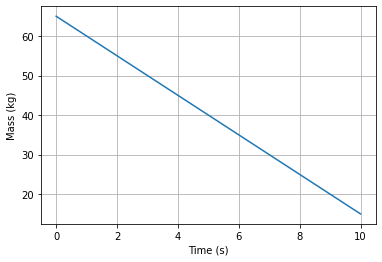

In [3]:
# Mass
dry_mass = 15
fuel_mass = 50
burn_time = 10
def mass_func(t):
    if t < burn_time:
        return dry_mass + fuel_mass - fuel_mass * t/burn_time     
    else:
        return dry_mass
    
mass = kiwi.Mass(mass_func, 'time')  # Function of time

# Plot to show what we're using
t_plot = np.linspace(0, 10, 100)
mass_plot = np.zeros(len(t_plot))

for i in range(len(t_plot)):
    mass_plot[i] = mass_func(t_plot[i])

plt.plot(t_plot, mass_plot)
plt.xlabel("Time (s)")
plt.ylabel("Mass (kg)")
plt.grid()
plt.show()

### Moments of Inertia

Approximately as a cylinder (Iyy = Izz = ml^2 / 12)

Ixx must be none zero to avoid a divide by zero error.

In [4]:
def m_o_i_func(t):
    # Rocket's x-x points along it's long axis
    Ixx = 1e-2
    Iyy = mass_func(t) / 12
    Izz = Iyy
    return [Ixx, Iyy, Izz]
    
moments_of_inertia = kiwi.MomentsOfInertia(m_o_i_func, 'time')

### Forces
- Thrust force
- Gravitational force (assume constant value of $g$)
- Axial and normal aerodynamic forces

In [5]:
mdot = fuel_mass / burn_time        # Mass flow rate of engine exhaust
isp = 1500                          # Specific impulse in m/s
def thrust_func(state):
    t = state.time
    r = Rotation.from_quat(state.ang_pos)
    if t < burn_time:
        thrust = mdot * isp    
    else:
        thrust = 0
    thrust_body_frame = [thrust, 0, 0]
    thrust_absolute_frame = r.apply(thrust_body_frame)    # Rotate thrust to align with body axes
    return thrust_absolute_frame

def gravity_func(t):
    return [0, 0, -9.81 * mass_func(t)]

CD = 0.5            # Drag coefficient
CN_alpha = 13       # Normal force coefficient per radian of angle of attack
A = 0.07            # Frontal area (m2)
rail_length = 1     # Launch rail length (m)
def aero_force_func(state):
    rho = 1.2
    V = np.linalg.norm(state.vel)
    if V < 1e-10:
        return [0, 0, 0]
    else:
        vel_unit = np.array(state.vel) / V
        FD =  -0.5 * rho * V**2 * A * CD * vel_unit
        
        if np.linalg.norm(state.pos) < rail_length:
            FN = 0
        else:
            r = Rotation.from_quat(state.ang_pos)
            body_xx = r.as_matrix()[:,0]           # First column of matrix represents the direction (in abs. frame) of body's x-axis
            alpha = np.arccos(np.dot(body_xx, vel_unit))
            CN = CN_alpha * alpha
            FN = 0.5 * rho * V**2 * A * CN * np.cross(body_xx, (np.cross(body_xx, vel_unit))) # Ref [1]
        return FD + FN

thrust = kiwi.Force(thrust_func, "state")
gravity = kiwi.Force(gravity_func, "time")
aero_force = kiwi.Force(aero_force_func, "state")

forces = [thrust, gravity, aero_force]

### Moments

Aerodynamic moment from FN.

In [6]:
def aero_force_moment(state):
    rho = 1.2
    V = np.linalg.norm(state.vel)
    if V < 1e-10:
        return [0,0,0]
    else:
        vel_unit = np.array(state.vel) / V
        r = Rotation.from_quat(state.ang_pos)
        body_xx = r.as_matrix()[:,0]          # First column of matrix represents the direction (in abs. frame) of body's x-axis
        alpha = np.arccos(np.dot(body_xx, vel_unit))
        CN = CN_alpha * alpha
        FN = 0.5 * rho * V**2 * CN * A * np.cross(body_xx, (np.cross(body_xx, vel_unit))) # Ref [1]
        COP_COG_vector = -body_xx * 0.1       # Distance between centre of gravity and where the force FN acts
        moment_abs_frame = np.cross(COP_COG_vector, FN) # Moment = (moment arm) x (force)
        r = Rotation.from_quat(state.ang_pos)
        rinv = r.inv()
        moment_body_frame = rinv.apply(moment_abs_frame)
        return moment_body_frame

aero_moment = kiwi.Moment(aero_force_moment, "state")
moments = [aero_moment]     

### Set up Body and Simulation

In [7]:
rocket = kiwi.Body(init_state, mass, moments_of_inertia, forces, moments)

# Simulation
def end_condition(state):
    z = state.pos[2]
    t = state.time
    
    if t < 2:
        return False
    elif z > 0:
        return False
    else:
        return True

simulation = kiwi.Simulation(rocket, dt = 0.05, end_condition = end_condition)
simulation.run(debug = False)

### Plot

Note that aspect ratio is not equal in 3D plot


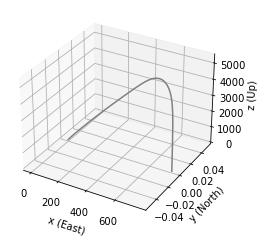

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(simulation.x(), simulation.y(), simulation.z(), 'gray')
ax.set_xlabel("x (East)")
ax.set_ylabel("y (North)")
ax.set_zlabel("z (Up)")
print("Note that aspect ratio is not equal in 3D plot")
plt.show()

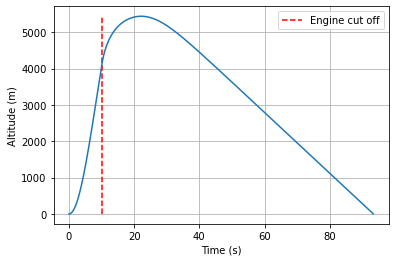

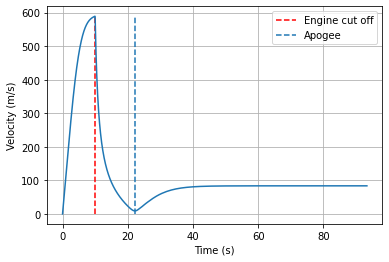

<ipython-input-9-bcc767b78462>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


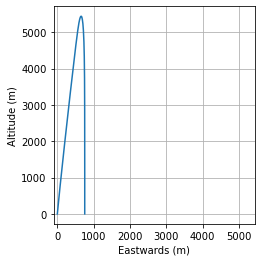

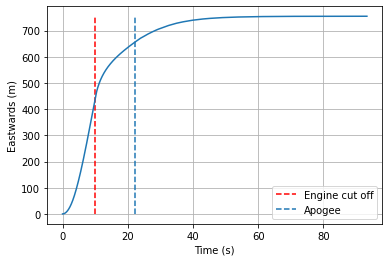

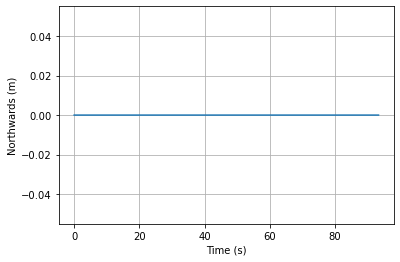

In [9]:
index_apogee = np.argmax(simulation.z())
t_apogee = simulation.t()[index_apogee]

plt.plot(simulation.t(), simulation.z())
plt.vlines(burn_time, ymin = min(simulation.z()), ymax = max(simulation.z()), label = "Engine cut off", linestyle = "--", color = "red")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.legend()
plt.grid()
plt.show()

plt.plot(simulation.t(), simulation.V())
plt.vlines(burn_time, ymin = min(simulation.V()), ymax = max(simulation.V()), label = "Engine cut off", linestyle = "--", color = "red")
plt.vlines(t_apogee, ymin = min(simulation.V()), ymax = max(simulation.V()), label = "Apogee", linestyle = "--")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

plt.plot(simulation.x(), simulation.z())
plt.xlabel("Eastwards (m)")
plt.ylabel("Altitude (m)")
plt.axes().set_aspect('equal')
plt.xlim(left = min(simulation.x()) - 100, right = max(simulation.z()))
plt.grid()
plt.show()

plt.plot(simulation.t(), simulation.x())
plt.vlines(burn_time, ymin = min(simulation.x()), ymax = max(simulation.x()), label = "Engine cut off", linestyle = "--", color = "red")
plt.vlines(t_apogee, ymin = min(simulation.x()), ymax = max(simulation.x()), label = "Apogee", linestyle = "--")
plt.xlabel("Time (s)")
plt.ylabel("Eastwards (m)")
plt.legend()
plt.grid()
plt.show()

plt.plot(simulation.t(), simulation.y())
plt.xlabel("Time (s)")
plt.ylabel("Northwards (m)")
plt.grid()
plt.show()

<ipython-input-10-fb86c5c9ce09>:7: RuntimeWarning: invalid value encountered in true_divide
  vel_unit = np.array(state.vel) / V


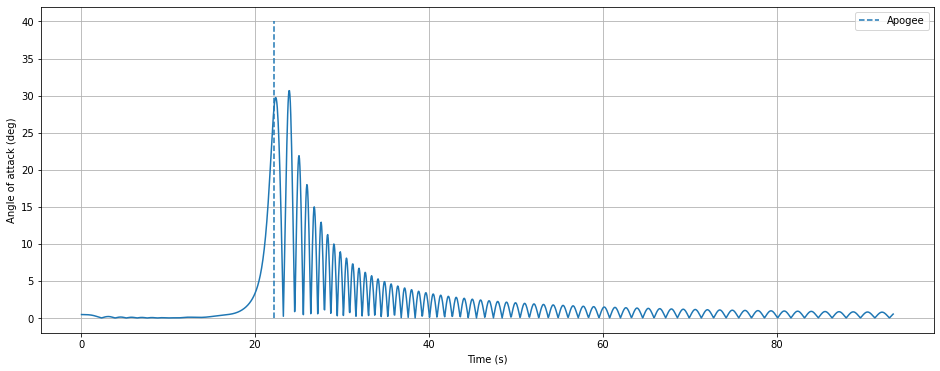

In [10]:
alpha = np.zeros(len(simulation.states))

for i in range(len(simulation.states)):
    state = simulation.states[i]
    V = np.linalg.norm(state.vel)

    vel_unit = np.array(state.vel) / V
    r = Rotation.from_quat(state.ang_pos)
    body_xx = r.as_matrix()[:,0]          # First column of matrix represents the direction (in abs. frame) of body's x-axis
    alpha[i] = np.arccos(np.dot(body_xx, vel_unit)) * 180 / np.pi
    

from matplotlib.pyplot import figure
figure(figsize=(16, 6))
plt.plot(simulation.t(), alpha)
plt.vlines(t_apogee, ymin = 0, ymax = 40, label = "Apogee", linestyle = "--")
plt.xlabel("Time (s)")
plt.ylabel("Angle of attack (deg)")
plt.legend()
plt.grid()
plt.show()